 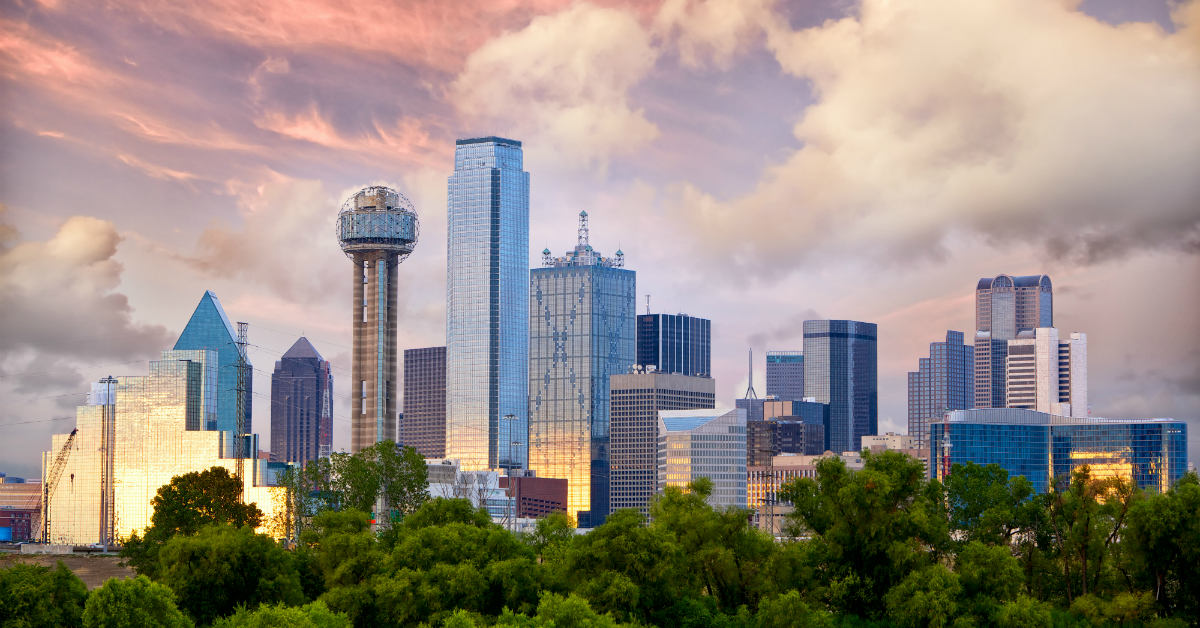

# <center>Market Analysis of Dallas</center> 


## 1. Introduction

### 1.1 Background

As part of the IBM Data Science Professional Certificate program, we explored New York City and Toronto venues to find hidden insights amongst the different venue locations. The final capstone project requires the learner to utilize data cleaning, preparation, visualization and modeling into their final report. The project will use the Foursquare API to build a data set with the different venues.

### 1.2 Problem

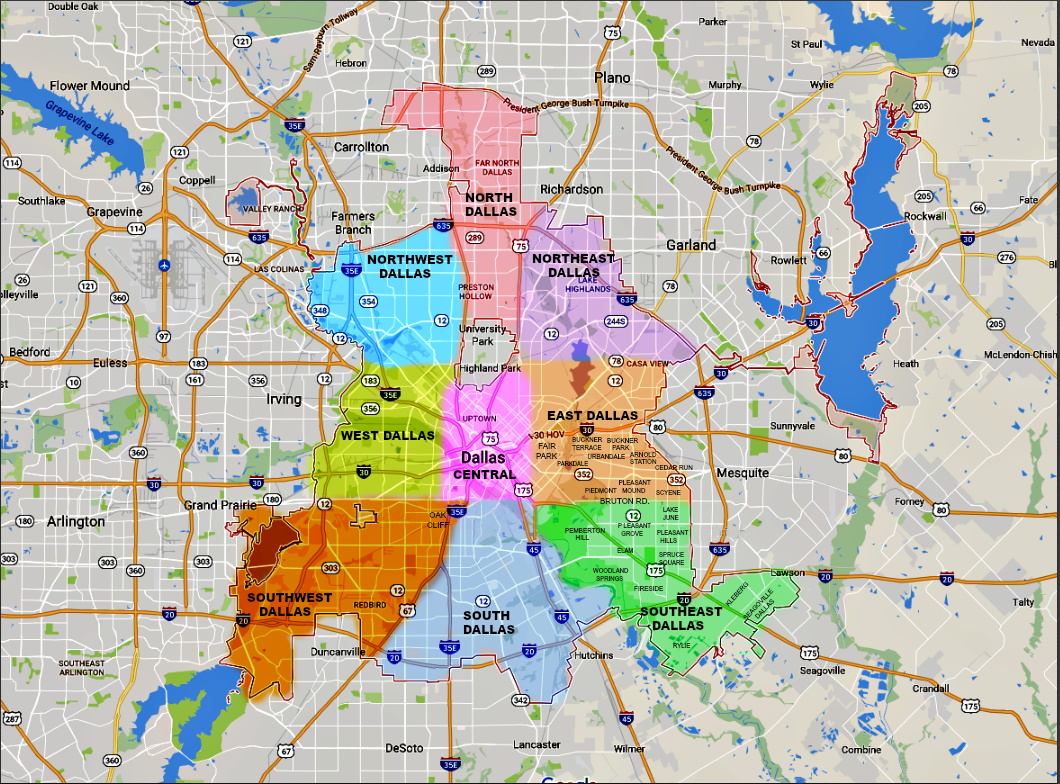

Dallas is the 9th populous city in America. With such a large population, new businesses may not know the prime locations to set up operations. Prime locations include spots where there are few competitors and/or large pedestrian traffic. This paper will seek to classify the different business markets in Dallas and the typical customer for a given neighborhood. 

### 1.3 Interest

*What type of clients or groups of people would be interested in this project?* 

1. Business Personnel looking to move operations into Texas. For a company, the environment they operate a business in is key to their success. This paper will explore and compare the different markets within Houston and Dallas, allowing key decision makers to determine the best location for new operations.

2. Travelers looking to explore Dallas or Houston as a vacation spot.

3. Houstonians or those from Dallas who want empirical evidence (or the lack of) as justification to denigrate the other city. Rivalry amongst the two city is a part of Texan culture. The results in the paper may further exacerbate this mentality.

## 2. Data Acquisition and Cleaning

### 2.1 Data Sources

We will web scrape Dallas neighborhood information from wikipedia. From here, we will use a geolocation service to map the name of the neighborhood to the latitude and longitude. Finally, we will use the Foursquare API to create a data set containing top venues for a given neighborhood.

First we will download and import packages for the project

In [1]:
!conda install beautifulsoup4 --yes
!conda install lxml --yes
!conda install html5lib
!conda install -c conda-forge geopy --yes
!pip install geocoder

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.8.2       |           py36_0         161 KB
    certifi-2019.11.28         |           py36_0         156 KB
    soupsieve-1.9.5            |           py36_0          61 KB
    openssl-1.1.1d             |       h7b6447c_3         3.7 MB
    ------------------------------------------------------------
                                           Total:         4.1 MB

The following NEW packages will be INSTALLED:

    soupsieve:      1.9.5-py36_0                 

The following packages will b

In [35]:
%matplotlib inline
import pandas as pd
import numpy as np
import requests #for retrieving web data
from bs4 import BeautifulSoup #
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium #Create visualizations
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import geocoder
import matplotlib.pyplot as plt 
import re

### 2.2 Data Cleaning 

We will start by scraping neighborhood information in Dallas from wikipedia using  *requests*, *BeautifulSoup* and *Pandas* for later analysis. 

In [3]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Dallas")
soup = BeautifulSoup(res.content,'html.parser')
Dallas_Neighborhoods_Uncleaned = soup.find_all('table',{"class":"wikitable"})
print(len(Dallas_Neighborhoods_Uncleaned))

12


Lets store these tables into a dictionary of dataframes

In [4]:
Dallas_Neighborhoods_Table_Uncleaned = {'Table {}'.format(i): pd.read_html(str(Dallas_Neighborhoods_Uncleaned[i-1]), flavor='html5lib', header=0)[0] for i in range(1,len(Dallas_Neighborhoods_Uncleaned)+1 )}

We will check out how many columns there are for each of the neighborhoods.

In [5]:
for i in range(1,len(Dallas_Neighborhoods_Table_Uncleaned)+1):
    print ('There are ' + str(len(Dallas_Neighborhoods_Table_Uncleaned['Table {}'.format(i)].columns)) + ' columns in Table {}'.format(i))

There are 3 columns in Table 1
There are 3 columns in Table 2
There are 3 columns in Table 3
There are 3 columns in Table 4
There are 3 columns in Table 5
There are 3 columns in Table 6
There are 3 columns in Table 7
There are 3 columns in Table 8
There are 3 columns in Table 9
There are 3 columns in Table 10
There are 3 columns in Table 11
There are 3 columns in Table 12


When looking at the second table, we see that there is another area embedded from the webscraping.

In [6]:
Dallas_Neighborhoods_Table_Uncleaned['Table 1']

,Downtown Dallas[1],Downtown Dallas[1].1,Downtown Dallas[1].2
0,NaN,Baylor District,Mixed
1,NaN,The Cedars,Mixed
2,NaN,Civic Center District,Mixed
3,NaN,Dallas Arts District,Mixed
4,NaN,Dallas Farmers Market,Mixed
5,NaN,Deep Ellum,Mixed
6,NaN,Design District,Mixed
7,NaN,Main Street District,Mixed
8,NaN,Reunion District,Commercial
9,NaN,Riverfront District,Mixed


We will parse through the existing tables and validate that the values are null in the first column. If there is a table with non null values in the first column, we will assume that the value is another table and create a new table from here.   

In [7]:
#Will create a function that takes in unfiltered dictionary and returns dictionary of dataframes with first columns having value null 
def filter_areas(table_dict):
    filtered_dict = {}
    for table_index in table_dict: #check if first column contains all null values, continue if true, else split table at non null values
        
        table = table_dict[table_index]
        first_column = table[table.columns[0]]
    
        if (first_column.isnull().all()):
            filtered_dict[table_index] = table_dict[table_index]
            continue
        
        area2 = first_column.first_valid_index()
        first_table, second_table = table[:area2], table[area2:]
        filtered_dict[table_index], filtered_dict[table_index+' new'] = first_table, second_table
    return filtered_dict

In [8]:
filtered_table = filter_areas(Dallas_Neighborhoods_Table_Uncleaned)

In [9]:
filtered_table

{'Table 1':     Downtown Dallas[1]            Downtown Dallas[1].1 Downtown Dallas[1].2
 0                  NaN                 Baylor District                Mixed
 1                  NaN                      The Cedars                Mixed
 2                  NaN           Civic Center District                Mixed
 3                  NaN            Dallas Arts District                Mixed
 4                  NaN           Dallas Farmers Market                Mixed
 5                  NaN                      Deep Ellum                Mixed
 6                  NaN                 Design District                Mixed
 7                  NaN            Main Street District                Mixed
 8                  NaN                Reunion District           Commercial
 9                  NaN             Riverfront District                Mixed
 10                 NaN                      South Side                Mixed
 11                 NaN  Thanksgiving Commercial Center          

Next we will merge these information into a dataframe with the Dallas areas, neighborhoods and community type

In [10]:
for table_index in filtered_table:
    table = filtered_table[table_index]
    table_area = table.columns[0]
    table[table_area].fillna(table_area, inplace=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [11]:
filtered_table

{'Table 1':     Downtown Dallas[1]            Downtown Dallas[1].1 Downtown Dallas[1].2
 0   Downtown Dallas[1]                 Baylor District                Mixed
 1   Downtown Dallas[1]                      The Cedars                Mixed
 2   Downtown Dallas[1]           Civic Center District                Mixed
 3   Downtown Dallas[1]            Dallas Arts District                Mixed
 4   Downtown Dallas[1]           Dallas Farmers Market                Mixed
 5   Downtown Dallas[1]                      Deep Ellum                Mixed
 6   Downtown Dallas[1]                 Design District                Mixed
 7   Downtown Dallas[1]            Main Street District                Mixed
 8   Downtown Dallas[1]                Reunion District           Commercial
 9   Downtown Dallas[1]             Riverfront District                Mixed
 10  Downtown Dallas[1]                      South Side                Mixed
 11  Downtown Dallas[1]  Thanksgiving Commercial Center          

Now we will merge into 1 Dallas_DF dataframe

In [12]:
DF_DALLAS = pd.DataFrame(columns=['Area','Neighborhood','Community'])

for table_index in filtered_table:
    table = filtered_table[table_index]
    table.columns = DF_DALLAS.columns
    DF_DALLAS = DF_DALLAS.append(table, ignore_index=True)

In [13]:
DF_DALLAS.replace({'Downtown Dallas[1]':'Downtown Dallas'}, inplace=True)

In [14]:
DF_DALLAS.head(10)

,Area,Neighborhood,Community
0,Downtown Dallas,Baylor District,Mixed
1,Downtown Dallas,The Cedars,Mixed
2,Downtown Dallas,Civic Center District,Mixed
3,Downtown Dallas,Dallas Arts District,Mixed
4,Downtown Dallas,Dallas Farmers Market,Mixed
5,Downtown Dallas,Deep Ellum,Mixed
6,Downtown Dallas,Design District,Mixed
7,Downtown Dallas,Main Street District,Mixed
8,Downtown Dallas,Reunion District,Commercial
9,Downtown Dallas,Riverfront District,Mixed


In [15]:
print ("There are %s Neighborhoods in Dallas" %DF_DALLAS.shape[0])

There are 205 Neighborhoods in Dallas


In [16]:
print('Dallas Area \t\t    Count\n',DF_DALLAS['Area'].value_counts(),sep = '\n')

Dallas Area 		    Count

Northeast Dallas              42
East Dallas                   41
Oak Cliff Area                22
Southeast Dallas              21
Downtown Dallas               15
North Dallas                  15
Old South Dallas/Fair Park    12
West Dallas                   11
Oak Lawn                      11
Northwest Dallas               7
Far South Dallas               3
South Central Dallas           2
Old East Dallas                1
Far North Dallas               1
Redbird                        1
Name: Area, dtype: int64


### Exploratory Data Analysis

Now that we have our dataframe set up, we will begin some exploratory data analysis.

Let's check out the communities in Dallas

In [17]:
DF_DALLAS.groupby('Community').count()

,Area,Neighborhood
Community,,
Commercial,8,8
Entertainment,3,3
Far North Dallas,1,1
Mixed,25,25
Old East Dallas,1,1
Redbird,1,1
Residential,165,165
Residential\,1,1


There are a few spots that we need to clean up. First we'll replace 'Residential\' with 'Residential' and investigate 'Far North Dallas' 'Old East Dallas' and 'Redbird', which may be the tables we created earlier

In [18]:
DF_DALLAS.replace({'Residential\\':'Residential' }, inplace=True)

In [19]:
DF_DALLAS.groupby('Community').count()

,Area,Neighborhood
Community,,
Commercial,8,8
Entertainment,3,3
Far North Dallas,1,1
Mixed,25,25
Old East Dallas,1,1
Redbird,1,1
Residential,166,166


In [20]:
DF_DALLAS.loc[DF_DALLAS['Community'].isin(['Old East Dallas','Redbird','Far North Dallas'])]

,Area,Neighborhood,Community
49,Old East Dallas,Old East Dallas,Old East Dallas
107,Far North Dallas,Far North Dallas,Far North Dallas
141,Redbird,Redbird,Redbird


Lets drop these rows and reindex our dataframe

In [21]:
DF_DALLAS.drop([49,107,141],inplace=True)

In [22]:
DF_DALLAS.groupby('Community').count()

,Area,Neighborhood
Community,,
Commercial,8,8
Entertainment,3,3
Mixed,25,25
Residential,166,166


We will one hot encode the community columns.

In [23]:
DF_DALLAS_ONEHOT = pd.get_dummies(DF_DALLAS['Community'], prefix="", prefix_sep="")
DF_DALLAS_ONEHOT[['Area','Neighborhood']] = DF_DALLAS[['Area','Neighborhood']] 
DF_DALLAS_ONEHOT.head()

,Commercial,Entertainment,Mixed,Residential,Area,Neighborhood
0,0,0,1,0,Downtown Dallas,Baylor District
1,0,0,1,0,Downtown Dallas,The Cedars
2,0,0,1,0,Downtown Dallas,Civic Center District
3,0,0,1,0,Downtown Dallas,Dallas Arts District
4,0,0,1,0,Downtown Dallas,Dallas Farmers Market


In [24]:
DF_DALLAS_ONEHOT.replace({0:np.nan}).groupby('Area').count()

,Commercial,Entertainment,Mixed,Residential,Neighborhood
Area,,,,,
Downtown Dallas,2,0,13,0,15
East Dallas,0,1,1,39,41
Far South Dallas,0,0,0,3,3
North Dallas,2,0,0,13,15
Northeast Dallas,0,0,1,41,42
Northwest Dallas,2,0,2,3,7
Oak Cliff Area,0,1,0,21,22
Oak Lawn,2,0,7,2,11
Old South Dallas/Fair Park,0,1,1,10,12


Lets try to visualize this information

In [25]:
DF_DALLAS_GROUPBY_AREA = DF_DALLAS_ONEHOT.replace({0:np.nan}).groupby('Area').count()

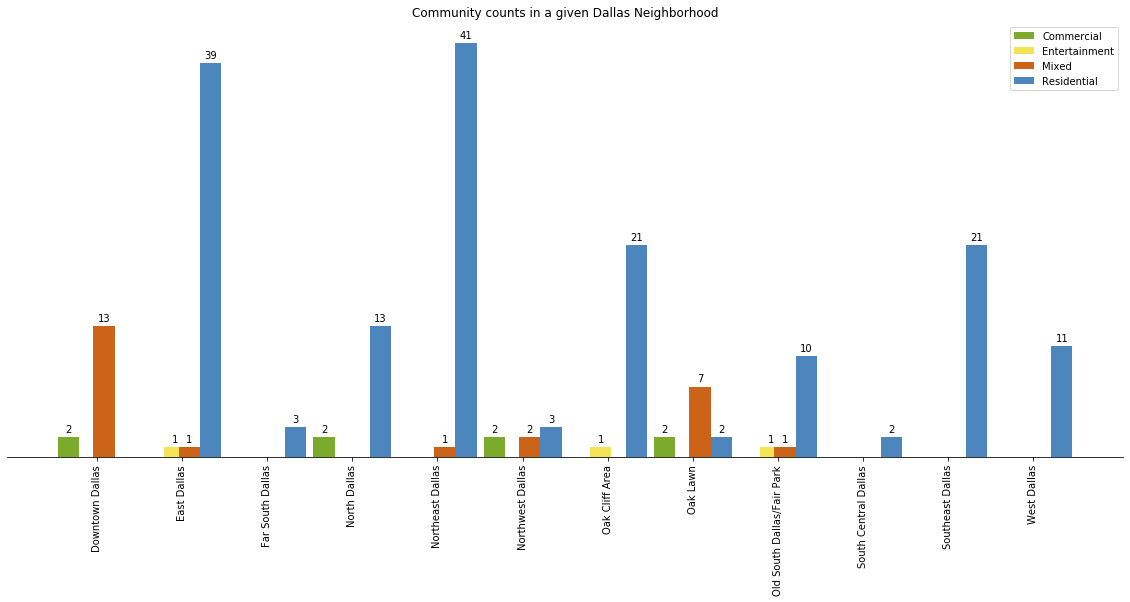

In [26]:
community_catagories = ['Commercial', 'Entertainment','Mixed','Residential']
numcategories = np.arange(len(DF_DALLAS_GROUPBY_AREA.index))
fig, ax = plt.subplots(figsize=(20,8))
w= 0.25
plt_commercial =  ax.bar(numcategories-4*w/3, DF_DALLAS_GROUPBY_AREA['Commercial'], width=w, color=['#7caa2d'],label=community_catagories[0],align='center')
plt_entertainment =  ax.bar(numcategories-w/3, DF_DALLAS_GROUPBY_AREA['Entertainment'], width=w, color=['#f5e356'],label=community_catagories[1],align='center')
plt_mixed =  ax.bar(numcategories+w/3, DF_DALLAS_GROUPBY_AREA['Mixed'], width=w, color=['#cb6318'],label=community_catagories[2],align='center')
plt_residential =  ax.bar(numcategories+4*w/3, DF_DALLAS_GROUPBY_AREA['Residential'], width=w, color=['#4d85bd'],label=community_catagories[3],align='center')
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks([])
plt.xticks(numcategories,DF_DALLAS_GROUPBY_AREA.index, rotation='vertical')
plt.title("Community counts in a given Dallas Neighborhood")
def autolabel(rects):
    for rect in rects:
        height = np.round(rect.get_height(),decimals=2)
        if height == 0:
            continue
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x()+rect.get_width()/2, height),
                    xytext=(0,3),
                    textcoords='offset points',
                    ha='center',va='bottom')
autolabel(plt_commercial)
autolabel(plt_entertainment)
autolabel(plt_mixed)
autolabel(plt_residential)

plt.legend()
plt.show()

Here we gain a little bit of insight as to what types of neighborhoods populate the different Dallas Areas.

We will narrow down our investigation to Downtown Dallas for market analysis. The analysis used can extend to the other neighborhoods of Dallas.

In [27]:
DF_DOWNTOWN_DALLAS = DF_DALLAS_ONEHOT.loc[DF_DALLAS_ONEHOT['Area'] == 'Downtown Dallas']
DF_DOWNTOWN_DALLAS.head()

,Commercial,Entertainment,Mixed,Residential,Area,Neighborhood
0,0,0,1,0,Downtown Dallas,Baylor District
1,0,0,1,0,Downtown Dallas,The Cedars
2,0,0,1,0,Downtown Dallas,Civic Center District
3,0,0,1,0,Downtown Dallas,Dallas Arts District
4,0,0,1,0,Downtown Dallas,Dallas Farmers Market


We'll need to get geo location Downtown Dallas if we want to perform analysis with the foursquare api. To even get the geolocation, we'll need to find the zip codes for all of the Neighborhoods downtown. First we'll use zip-codes.com to scrape the zip code and city name.

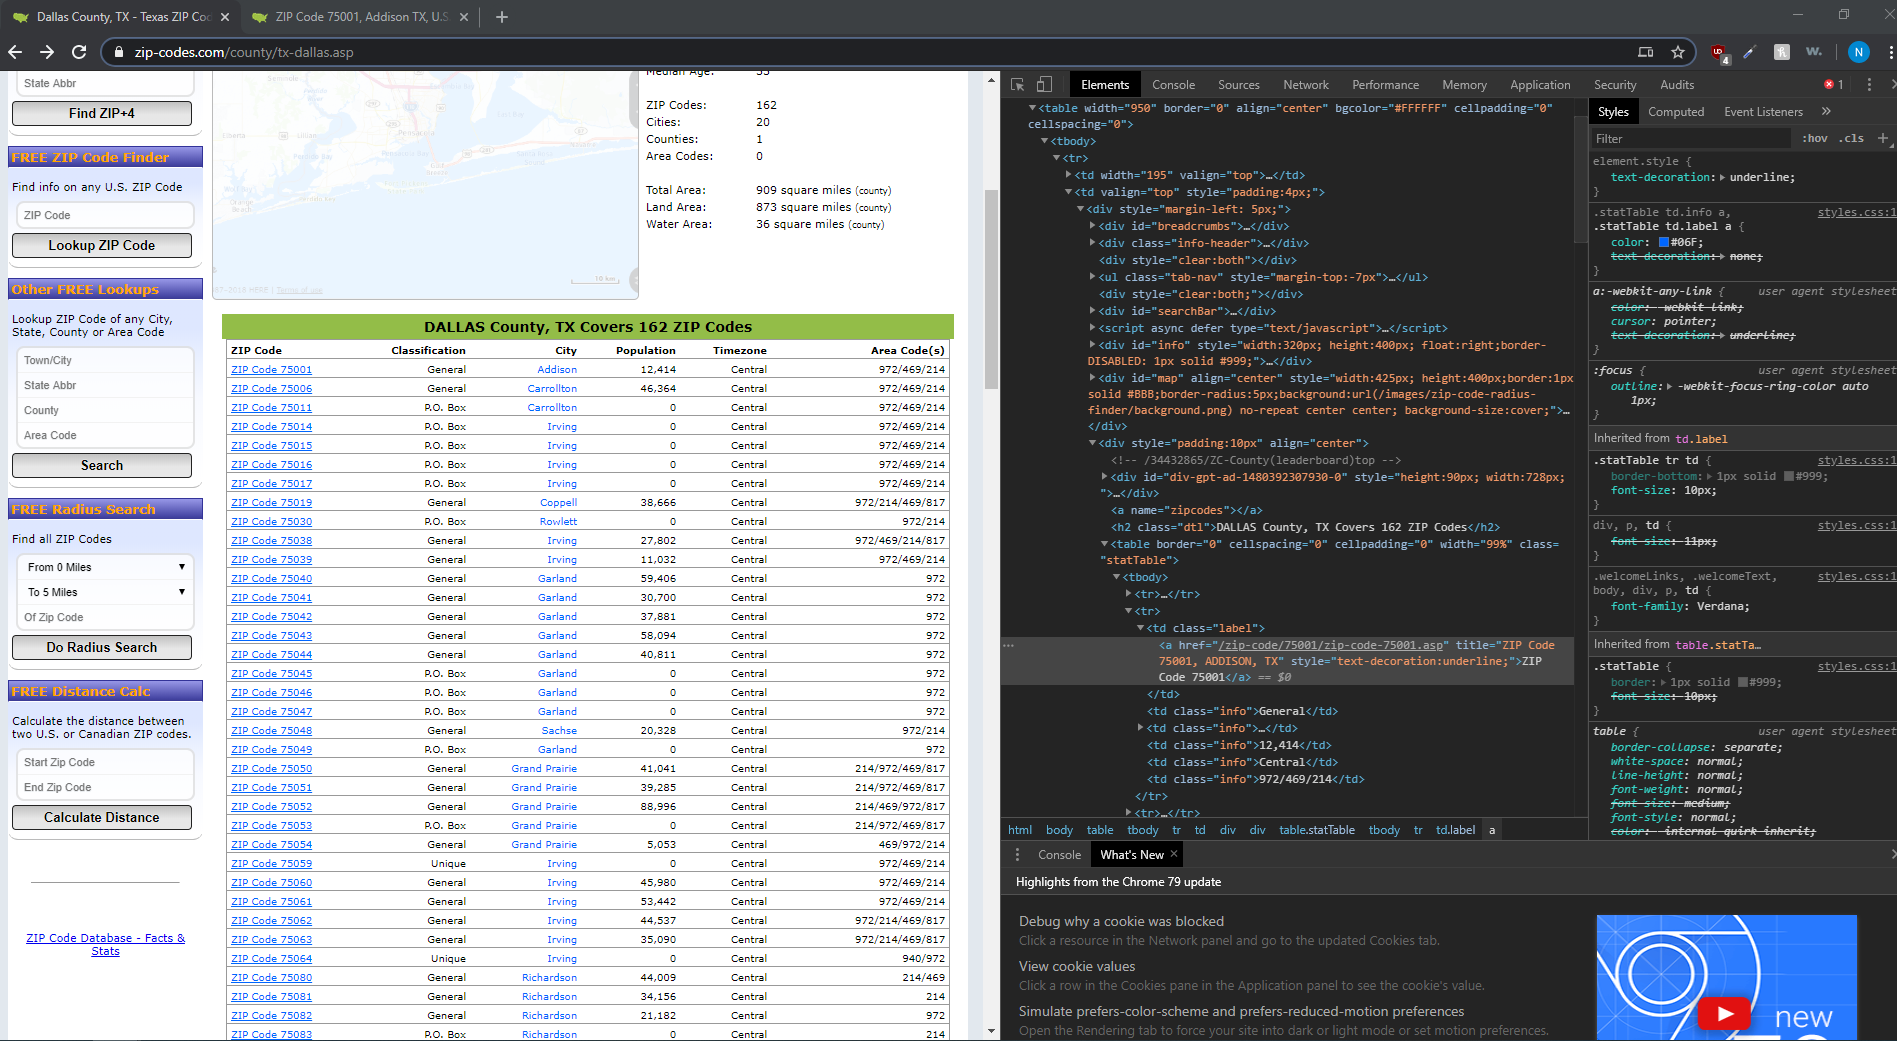

Now we have all of the links for the Dallas Zip codes stored in the variable zip_code_links. We'll need to extract the value and href of each link tag and put them into a dataframe if we want to use it later.

In [57]:
dallas_zip_home = "https://www.zip-codes.com/county/tx-dallas.asp"
zip_home = "https://www.zip-codes.com"
res = requests.get(dallas_zip_home)
soup = BeautifulSoup(res.content,'html.parser')
zip_code_links = [[link.get_text()[-5:],link.get("href")] for link in soup.find_all('a',{"href":re.compile(r'/zip-code/\d\d\d\d\d/zip-code-\d\d\d\d\d')})]
print(zip_code_links)

[['75001', '/zip-code/75001/zip-code-75001.asp'], ['75006', '/zip-code/75006/zip-code-75006.asp'], ['75011', '/zip-code/75011/zip-code-75011.asp'], ['75014', '/zip-code/75014/zip-code-75014.asp'], ['75015', '/zip-code/75015/zip-code-75015.asp'], ['75016', '/zip-code/75016/zip-code-75016.asp'], ['75017', '/zip-code/75017/zip-code-75017.asp'], ['75019', '/zip-code/75019/zip-code-75019.asp'], ['75030', '/zip-code/75030/zip-code-75030.asp'], ['75038', '/zip-code/75038/zip-code-75038.asp'], ['75039', '/zip-code/75039/zip-code-75039.asp'], ['75040', '/zip-code/75040/zip-code-75040.asp'], ['75041', '/zip-code/75041/zip-code-75041.asp'], ['75042', '/zip-code/75042/zip-code-75042.asp'], ['75043', '/zip-code/75043/zip-code-75043.asp'], ['75044', '/zip-code/75044/zip-code-75044.asp'], ['75045', '/zip-code/75045/zip-code-75045.asp'], ['75046', '/zip-code/75046/zip-code-75046.asp'], ['75047', '/zip-code/75047/zip-code-75047.asp'], ['75048', '/zip-code/75048/zip-code-75048.asp'], ['75049', '/zip-cod

Next we will add this information into a dataframe

In [59]:
zip_code_df = pd.DataFrame(zip_code_links, columns=['Zip Code','Link'])
zip_code_df.head()

,Zip Code,Link
0,75001,/zip-code/75001/zip-code-75001.asp
1,75006,/zip-code/75006/zip-code-75006.asp
2,75011,/zip-code/75011/zip-code-75011.asp
3,75014,/zip-code/75014/zip-code-75014.asp
4,75015,/zip-code/75015/zip-code-75015.asp


We'll use the geocoder api to try and get the latitude/longitude information for a given neighborhood.

In [27]:
lat_lng_coords = None
location =  DF_DALLAS['Neighborhood'][0]+ ', TX'
while (lat_lng_coords is None):
    g = geocoder.google(location)
    print(g)
    lat_lng_coords = g.latlng

latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]

<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geoco

Status code Unknown from https://maps.googleapis.com/maps/api/geocode/json: ERROR - HTTPSConnectionPool(host='maps.googleapis.com', port=443): Read timed out. (read timeout=5.0)


<[ERROR - HTTPSConnectionPool(host='maps.googleapis.com', port=443): Read timed out. (read timeout=5.0)] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocod

Status code Unknown from https://maps.googleapis.com/maps/api/geocode/json: ERROR - HTTPSConnectionPool(host='maps.googleapis.com', port=443): Read timed out. (read timeout=5.0)


<[ERROR - HTTPSConnectionPool(host='maps.googleapis.com', port=443): Read timed out. (read timeout=5.0)] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocode [empty]>
<[REQUEST_DENIED] Google - Geocod

KeyboardInterrupt: 

## 3. Methodology

## 4. Results

## 5. Discussion

## 6. Conclusion